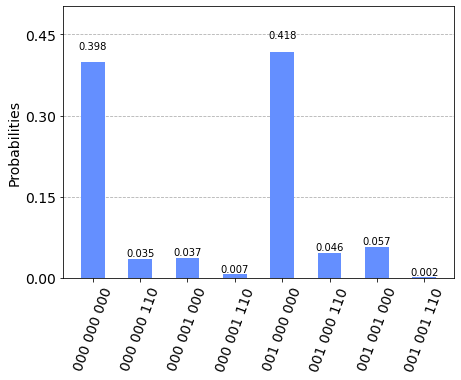

In [8]:
from qiskit.providers.aer.noise import pauli_error, NoiseModel, QuantumError
from qiskit import *
from qiskit.circuit.library import IGate, MCMT
from qiskit.providers.aer import QasmSimulator
from qiskit.tools.visualization import plot_histogram

probError = 0.1
bitflipError = pauli_error([('X', probError),('I', 1 - probError)])
phaseflipError = pauli_error([('Z', probError),('I', 1 - probError)])
errorGate1 = IGate(label="EX")  
errorGate2 = IGate(label="EZ")  
noise = NoiseModel()
noise.add_all_qubit_quantum_error(bitflipError, "EX")
noise.add_all_qubit_quantum_error(phaseflipError, "EZ")

cx3 = MCMT(gate = 'x', num_ctrl_qubits=1, num_target_qubits=3)
cx2 = MCMT(gate = 'x', num_ctrl_qubits=1, num_target_qubits=2)
cz4 = MCMT(gate = 'z', num_ctrl_qubits=1, num_target_qubits=4)
cx4 = MCMT(gate = 'x', num_ctrl_qubits=1, num_target_qubits=4)
ar = QuantumRegister(6, 'a')
qr = QuantumRegister(7, 'q')
cr1 = ClassicalRegister(3)
cr2 = ClassicalRegister(3)
cr3 = ClassicalRegister(3)
qc = QuantumCircuit(ar, qr, cr1, cr2, cr3)

## ENCODNG ##
qc.h(9)
qc.h(10)
qc.h(11)
qc.h(12)
qc.append(cx2,[qr[3],qr[1],qr[2]])
qc.append(cx3,[qr[4],qr[0],qr[2],qr[3]])
qc.append(cx3,[qr[5],qr[0],qr[1],qr[3]])
qc.append(cx3,[qr[6],qr[0],qr[1],qr[2]])

## ERROR ##

qc.append(errorGate1,[10])
qc.append(errorGate2,[7])

## SYNDROME EXTRACTION ##

qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.h(4)
qc.h(5)
qc.append(cz4,[ar[5],qr[0],qr[1],qr[2],qr[6]])
qc.append(cz4,[ar[4],qr[0],qr[1],qr[3],qr[5]])
qc.append(cz4,[ar[3],qr[0],qr[2],qr[3],qr[4]])
qc.append(cx4,[ar[2],qr[0],qr[1],qr[2],qr[6]])
qc.append(cx4,[ar[1],qr[0],qr[1],qr[3],qr[5]])
qc.append(cx4,[ar[0],qr[0],qr[2],qr[3],qr[4]])
qc.h(0)
qc.h(1)
qc.h(2)
qc.h(3)
qc.h(4)
qc.h(5)

qc.measure([0, 1, 2], [0, 1, 2])
qc.measure([3, 4, 5], [3, 4, 5])

## ERROR CORRECTION ##

qc.x(qr[0]).c_if(cr2, 111)
qc.x(qr[1]).c_if(cr2, 110)
qc.x(qr[2]).c_if(cr2, 101)
qc.x(qr[3]).c_if(cr2, 0b11)
qc.x(qr[4]).c_if(cr2, 0b01)
qc.x(qr[5]).c_if(cr2, 0b10)
qc.x(qr[6]).c_if(cr2, 100)

qc.z(qr[0]).c_if(cr1, 111)
qc.z(qr[1]).c_if(cr1, 110)
qc.z(qr[2]).c_if(cr1, 101)
qc.z(qr[3]).c_if(cr1, 0b11)
qc.z(qr[4]).c_if(cr1, 0b01)
qc.x(qr[5]).c_if(cr1, 0b10)
qc.z(qr[6]).c_if(cr1, 100)

## DECODER ##

qc.append(cx3,[qr[6],qr[0],qr[1],qr[2]])
qc.append(cx3,[qr[5],qr[0],qr[1],qr[3]])
qc.append(cx3,[qr[4],qr[0],qr[2],qr[3]])
qc.append(cx2,[qr[3],qr[1],qr[2]])
qc.h(10)
qc.h(11)
qc.h(12)

qc.measure([9], [6])

noisy_simulator = QasmSimulator(noise_model = noise)
job = execute(qc, noisy_simulator)
result = job.result()
counts= result.get_counts(0)
plot_histogram(counts)

#qc.draw(scale = 1, output = 'mpl')